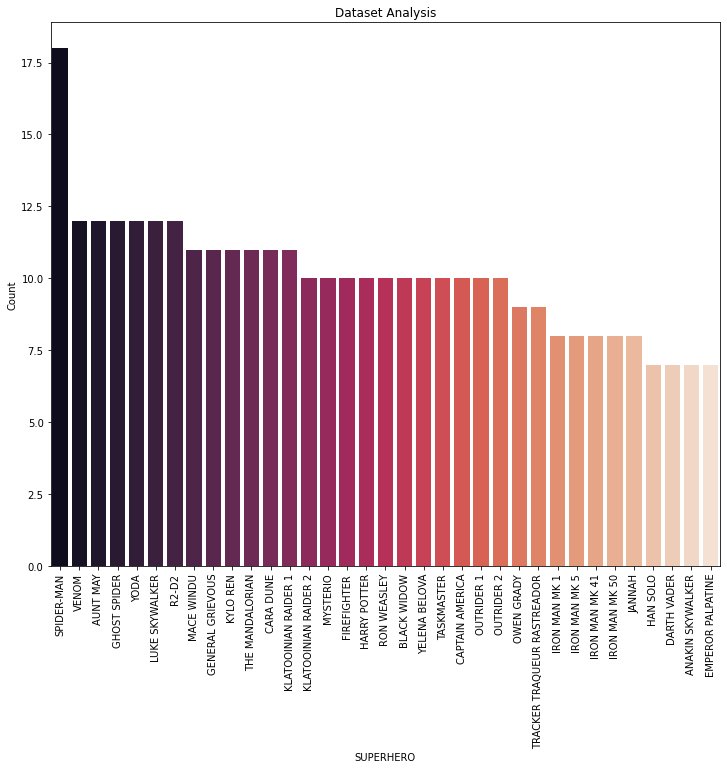

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 32)     

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
os.listdir('/content/drive/MyDrive/Data')

index=pd.read_csv('/content/drive/MyDrive/Data/index.csv')
index.head()

metadata=pd.read_csv('/content/drive/MyDrive/Data/metadata.csv')
metadata.head()

df = pd.merge(index, metadata[['class_id', 'minifigure_name']], on='class_id')
df.head()

#CHECKING IF THE IS ANY MISSING VALUES
df.isnull().sum()

hero_name=df['minifigure_name'].unique()
hero_name

count=df['minifigure_name'].value_counts()
count

plt.figure(figsize=(12,10))
sns.barplot(x=hero_name, y=count,palette='rocket')

plt.xticks(rotation= 90)
plt.xlabel('SUPERHERO')
plt.ylabel('Count')
plt.title('Dataset Analysis')
plt.show()

#BUILDING THE MODEL
HERO=tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(512,512,3)),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Dropout(0.2),
                                  tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Dropout(0.2),
                                
                                tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512,activation='relu'),
                                tf.keras.layers.Dense(31,activation='softmax')])
HERO.summary()

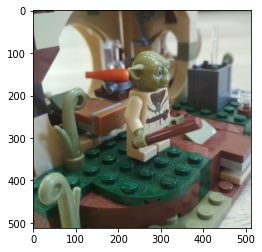

In [9]:
image = cv2.imread('/content/drive/MyDrive/Data/star-wars/0001/001.jpg')
image = cv2.resize(image, (512,512))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0

plt.imshow(image)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 351
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             352 non-null    object
 1   class_id         352 non-null    int64 
 2   train-valid      352 non-null    object
 3   minifigure_name  352 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.8+ KB


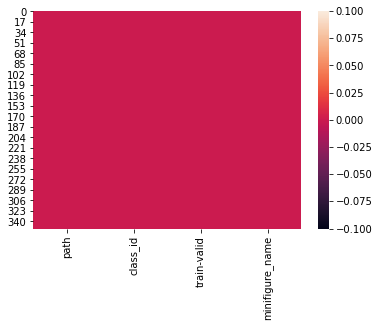

In [14]:
sns.heatmap(data= df.isnull())

In [6]:
#Splitting into train and validation

training = df[df["train-valid"] == 'train']
validation = df[df["train-valid"] == 'valid']
trainD = np.zeros((training.shape[0], 224, 224, 3))

for i in range(training.shape[0]):
    
    image = cv2.imread('/content/drive/MyDrive/Data/' + training["path"].values[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    

    trainD[i] = image / 255.0

trainL = np.array(training["class_id"])-1
validD = np.zeros((validation.shape[0], 224, 224, 3))

for i in range(validation.shape[0]):
    
    image = cv2.imread('/content/drive/MyDrive/Data/' + validation["path"].values[i])
    
    #Converting BGR to RGB 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (224,224))
    validD[i] = image / 255.0

validL = np.array(validation["class_id"])-1
class mycallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epochs,logs={}):
        if(logs.get('accuracy')>1.0):
            self.model.stop_training=True
def create_model(input_shape):
    # initialize the base model as VGG16 model with input shape as (512,512,3)
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape,
                       include_top = False,
                       weights = 'imagenet')

    # we do not have to train all of the layers
    for layer in base_model.layers:
        layer.trainable = False
        
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(36, activation = 'softmax')(x)
    
    return tf.keras.models.Model(base_model.input,x)
model = create_model((224,224,3))

In [7]:
callbacks=mycallbacks()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
             loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
history=model.fit(trainD,trainL,epochs=200,validation_data=(validD, validL),callbacks=[callbacks],shuffle=True,batch_size=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
42/42 [==============================] - 18s 364ms/step - loss: 7.6387 - accuracy: 0.0714 - val_loss: 2.4793 - val_accuracy: 0.3310
Epoch 2/200
42/42 [==============================] - 14s 343ms/step - loss: 1.6754 - accuracy: 0.5429 - val_loss: 2.3015 - val_accuracy: 0.3592
Epoch 3/200
42/42 [==============================] - 15s 348ms/step - loss: 0.7527 - accuracy: 0.7667 - val_loss: 1.8752 - val_accuracy: 0.4930
Epoch 4/200
42/42 [==============================] - 15s 350ms/step - loss: 0.4276 - accuracy: 0.8571 - val_loss: 1.8997 - val_accuracy: 0.5211
Epoch 5/200
42/42 [==============================] - 14s 346ms/step - loss: 0.4316 - accuracy: 0.8429 - val_loss: 1.6431 - val_accuracy: 0.6127
Epoch 6/200
42/42 [==============================] - 15s 351ms/step - loss: 0.2855 - accuracy: 0.9095 - val_loss: 1.7669 - val_accuracy: 0.5704
Epoch 7/200
42/42 [==============================] - 14s 348ms/step - loss: 0.2346 - accuracy: 0.9143 - val_loss: 1.6811 - val_accuracy:

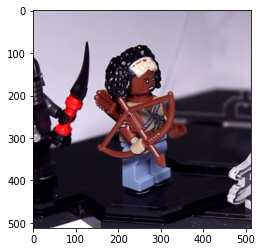

In [15]:
testImage = cv2.imread('/content/drive/MyDrive/Data/test/001.jpg')
testImage = cv2.resize(testImage, (512,512))
testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB) / 255.0

plt.imshow(testImage)

You can check the class_id of testImage from test.csv